In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import json
import random

In [33]:
working_dir = os.getcwd()
print(f"You are now working in {working_dir}")
print("If you need to change to the parent directory, run the cell below")

You are now working in c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN
If you need to change to the parent directory, run the cell below


In [ ]:
os.chdir(os.path.dirname(working_dir))
new_working_dir = os.getcwd()
print(f"You have now changed your working directory to {new_working_dir}")

In [34]:
version = 'v7'
file_path = f'outputs/{version}'
current_working_dir = os.getcwd()

if 'outputs' in os.listdir(current_working_dir) and version in os.listdir(current_working_dir + '/outputs'):
    print("This version already exists, create a new version if you are working on a new version")
    pass
else:
    os.makedirs(name=file_path)

This version already exists, create a new version if you are working on a new version


In [35]:
image_dirs = 'inputs/dataset/balanced/flower_photos'
train_path = image_dirs + '/train'
val_path = image_dirs + '/validation'
test_path = image_dirs + '/test'

In [36]:
labels = os.listdir(train_path)
print(f"Flower labels: {labels}")

Flower labels: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [39]:


class ImageClassificationPipeline:
    def __init__(self, train_path, val_path, test_path, input_shape=(224, 224, 3), batch_size=20, num_classes=5):
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes

        # Initialize ImageDataGenerators
        self.train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.10,
            height_shift_range=0.10,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )
        self.val_test_datagen = ImageDataGenerator(rescale=1./255)

        # Build data generators
        self.train_set = self.train_datagen.flow_from_directory(
            self.train_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=True
        )
        self.validation_set = self.val_test_datagen.flow_from_directory(
            self.val_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        self.test_set = self.val_test_datagen.flow_from_directory(
            self.test_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        print("Class indices:", self.train_set.class_indices)
        
        # Retrieve label map
        self.label_map = list(self.train_set.class_indices.keys())
        
        # Build model
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Conv2D(16, (3, 3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(pool_size=(2, 2)),
            
            Conv2D(32, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),            
            
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, epochs=25, early_stopping_patience=3):
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        
        self.history = self.model.fit(
            self.train_set,
            validation_data=self.validation_set,
            epochs=epochs,
            callbacks=[early_stop],
            verbose=1
        )

    def evaluate(self, savepath=None,  cm_image_path=None): 
        y_pred_probs = self.model.predict(self.test_set)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = self.test_set.classes

        # Calculate F1 score
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"F1 Score (weighted): {f1:.4f}")

        # Classification report
        report = classification_report(y_true, y_pred, target_names=self.label_map, output_dict=True)
        print("\nClassification Report:")
        print(report)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_map)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        if cm_image_path:
            disp.plot(cmap=plt.cm.Blues)
            plt.savefig(cm_image_path, bbox_inches='tight', dpi=150)
            print(f"Confusion matrix image saved as {cm_image_path}")
        
        # If savepath is given, save JSON-file
        if savepath:
            evaluation_data = {
                "f1_score_weighted": f1,
                "classification_report": report,
                "confusion_matrix": cm.tolist()  # Converts numpy array to list for JSON-file
            }

            # Saves data as JSON-file
            with open(savepath, 'w') as f:
                json.dump(evaluation_data, f, indent=4)
            print(f"Evaluation saved as {savepath}")

    def plot_training_history(self, savepath):
        plt.figure(figsize=(12, 5))
        
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
        plt.show()


    def save_model(self, filepath):
        self.model.save(filepath)
        print(f"Model saved as {filepath}")
        
    def model_summary(self):
        self.model.summary()
    

In [40]:
pipeline = ImageClassificationPipeline(train_path, val_path, test_path)
pipeline.train(epochs=25)
pipeline.save_model(f"{file_path}/flower_prediction_model.h5")


Found 25140 images belonging to 5 classes.
Found 3590 images belonging to 5 classes.
Found 7190 images belonging to 5 classes.
Class indices: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
Epoch 1/25
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 387s 307ms/step - accuracy: 0.4028 - loss: 1.3738 - val_accuracy: 0.6206 - val_loss: 0.9224
Epoch 2/25
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 385s 306ms/step - accuracy: 0.5766 - loss: 1.0323 - val_accuracy: 0.6474 - val_loss: 0.8372
Epoch 3/25
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 387s 308ms/step - accuracy: 0.6232 - loss: 0.9365 - val_accuracy: 0.6685 - val_loss: 0.8191
Epoch 4/25
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 389s 309ms/step - accuracy: 0.6514 - loss: 0.8826 - val_accuracy: 0.7192 - val_loss: 0.7093
Epoch 5/25
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 386s 307ms/step - accuracy: 0.6814 - loss: 0.8252 - val_accuracy: 0.7351 - val_loss: 0.6653
Epoch 6/25
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 388s 308ms/step - accuracy: 0.6810 - loss: 0.8094 - val_accuracy: 0.7471 - 

Model saved as outputs/v7/flower_prediction_model.h5


360/360 ━━━━━━━━━━━━━━━━━━━━ 98s 272ms/step
F1 Score (weighted): 0.8189

Classification Report:
{'daisy': {'precision': 0.9073243647234679, 'recall': 0.8442280945757997, 'f1-score': 0.8746397694524496, 'support': 1438.0}, 'dandelion': {'precision': 0.8511530398322851, 'recall': 0.847009735744089, 'f1-score': 0.8490763332171488, 'support': 1438.0}, 'roses': {'precision': 0.6769815418023887, 'recall': 0.8671766342141863, 'f1-score': 0.7603658536585366, 'support': 1438.0}, 'sunflowers': {'precision': 0.8973829201101928, 'recall': 0.9061196105702365, 'f1-score': 0.9017301038062284, 'support': 1438.0}, 'tulips': {'precision': 0.8065661047027507, 'recall': 0.6321279554937413, 'f1-score': 0.7087719298245614, 'support': 1438.0}, 'accuracy': 0.8193324061196106, 'macro avg': {'precision': 0.827881594234217, 'recall': 0.8193324061196107, 'f1-score': 0.8189167979917851, 'support': 7190.0}, 'weighted avg': {'precision': 0.827881594234217, 'recall': 0.8193324061196106, 'f1-score': 0.8189167979917849

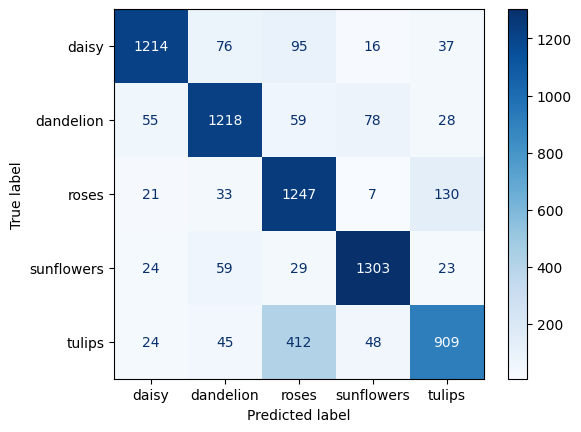

Confusion matrix image saved as outputs/v7/confusion_matrix.png
Evaluation saved as outputs/v7/model_evaluation.json


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,378,609 (31.96 MB)

 Trainable params: 2,792,869 (10.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,585,740 (21.31 MB)

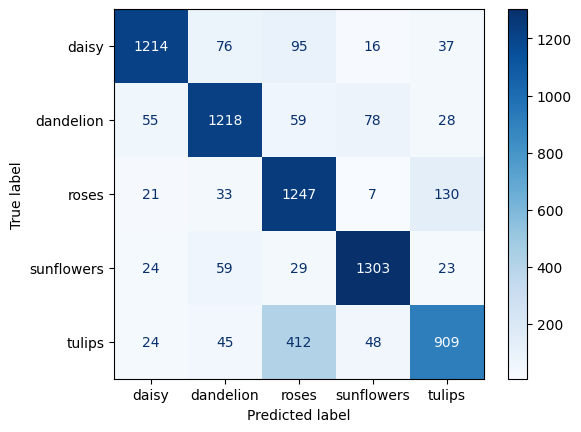

In [41]:
pipeline.evaluate(savepath=f"{file_path}/model_evaluation.json", cm_image_path=f"{file_path}/confusion_matrix.png")
pipeline.model_summary()

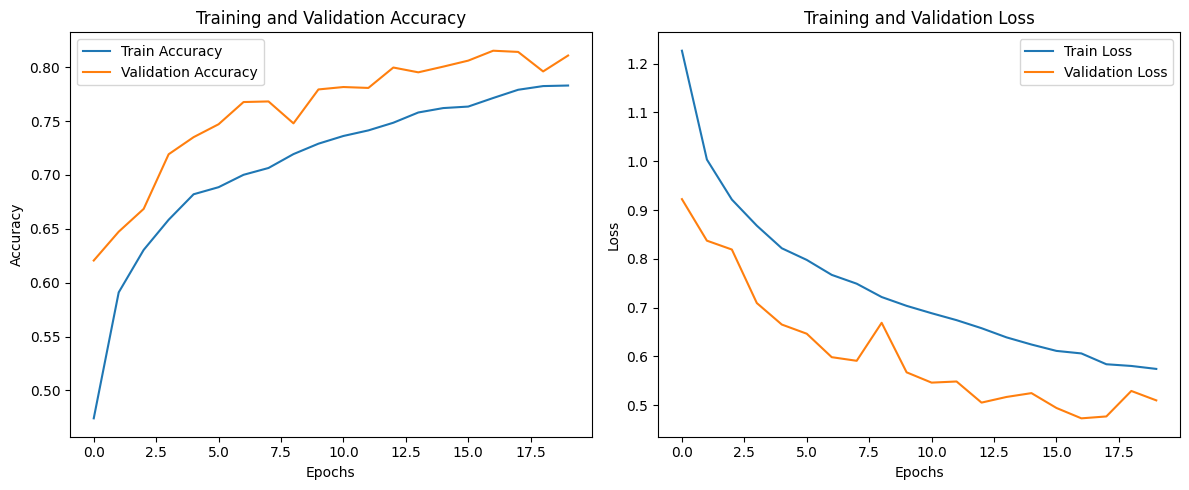

In [42]:
pipeline.plot_training_history(savepath=f"{file_path}/training_history.png")

In [43]:
json_file = f"{file_path}/model_evaluation.json"

with open(json_file, 'r') as f:
    evaluation_data = json.load(f)
    
print(f"Weighted F1 Score: {evaluation_data['f1_score_weighted']:.4}\n")


# Transforms the JSON-file to a more readable DataFrame
classification_report_df = pd.DataFrame(evaluation_data['classification_report']).transpose()
classification_report_df = classification_report_df.round(4)

classification_report_df = pd.concat([
    classification_report_df.iloc[:-3],  
    pd.DataFrame([[''] * len(classification_report_df.columns)], columns=classification_report_df.columns),  
    classification_report_df.iloc[-3:]  
]).reset_index()

classification_report_df.index.name = None

pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.width', 100)

print("Classification Report:\n", classification_report_df.to_string(index=False))

# Creates a DataFrame for the confussion matrix
labels = list(evaluation_data['classification_report'].keys())[:-3] # Excludes the last 3 labels
confussion_matrix_df = pd.DataFrame(
    evaluation_data['confusion_matrix'],
    index = labels,
    columns = labels
)

print("\nConfussion Matrix:\n", confussion_matrix_df)



Weighted F1 Score: 0.8189

Classification Report:
    index     precision  recall f1-score support
       daisy   0.9073   0.8442  0.8746   1438.0
   dandelion   0.8512    0.847  0.8491   1438.0
       roses    0.677   0.8672  0.7604   1438.0
  sunflowers   0.8974   0.9061  0.9017   1438.0
      tulips   0.8066   0.6321  0.7088   1438.0
           0                                   
    accuracy   0.8193   0.8193  0.8193   0.8193
   macro avg   0.8279   0.8193  0.8189   7190.0
weighted avg   0.8279   0.8193  0.8189   7190.0

Confussion Matrix:
             daisy  dandelion  roses  sunflowers  tulips
daisy       1214       76       95        16        37 
dandelion     55     1218       59        78        28 
roses         21       33     1247         7       130 
sunflowers    24       59       29      1303        23 
tulips        24       45      412        48       909 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


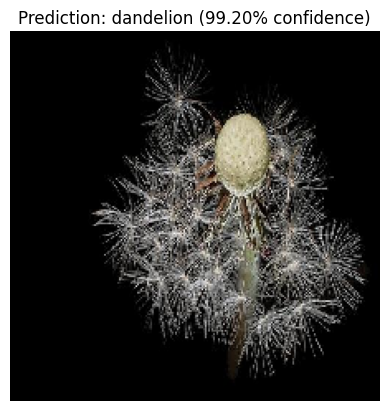

In [44]:
def predict_random_image(model, label_map, img_path, target_size=(224, 224)):
    
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Makes a prediction of a random image
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = label_map[predicted_class]
    confidence = predictions[0][predicted_class] * 100


    plt.imshow(img)
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}% confidence)")
    plt.axis('off')
    plt.show()


test_dir = "inputs/dataset/balanced/flower_photos/test"  
random_class = random.choice(os.listdir(test_dir))  # Choose a random image
random_img_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))

# Prediction of an image
predict_random_image(pipeline.model, pipeline.label_map, random_img_path)

<hr>

## Results


| Version | Balanced / Unbalanced | Layers           | Kernels       | Total params   | Runtime | Accuracy | F1-Score | Comments                                                        |
| ------- | --------------------- | ---------------- | -------------  | -------------- | ------- | -------- | -------- | --------------------------------------------------------------- |
| 1       | Unbalanced            | 32 - 64 - 128    | 3x3, 3x3, 3x3 | 33,508,817     | 209 min | 0.8329   | 0.8336   | Good result, though very large model file. Going to half the layers and see if the result will be the same and lesser size of the .h5-file |
| 2       | Unbalanced            | 16 - 32 - 64     | 3x3, 3x3, 3x3 | 8,378,609      | 124 min | 0.8258   | 0.8244   | Good result, almost the same result when decreasing the layers to the half of the first version. The model now are around 33Mb instead of over 130Mb with the first model |
| 3       | Unbalanced            | 16 - 32 - 64     | 5x5, 5x5, 5x5 | 7,274,993      | 156 min | 0.8167   | 0.8183   | Good result, almost identical even when increasing the kernel size. Still the largest confusion is between tulips and roses |
| 4       | Unbalanced            | 16 - 32 - 64     | 5x5, 5x5, 5x5 | 223,729      | 55 min | 0.7087   | 0.6998   | Tried GlobalAveragePooling2D instead of Flatten on this layer and it didn´t go so well. Changing back to Flatten for the next version and increasing the layers. |
| 5       | Unbalanced            | 32 - 64 - 64     | 5x5, 5x5, 5x5 | 14,627,857      | 347 min | 0.7021   | 0.6819   | Adjust the augmentation with this model and the performance decreased instead. Will try next time with a balanced version 2. See if the performance of that can increase |
| 6       | Balanced (Undersampled)           | 16 - 32 - 64     | 3x3, 3x3, 3x3 | 8,379,505      | 68 min | 0.3536   | 0.2851   | Poor result when undersampled the categories. Settings where the same as the best performance at version 2. Ran with BatchNormalization() that made a poor result |
| 6       | Balanced (Oversampled)           | 16 - 32 - 64     | 3x3, 3x3, 3x3 | 8,378,609      | 129 min | 0.8193   | 0.8189   | Deleted BatchNormalization in every layer and got a result very similar to version 2. Seems like oversampling didn´t do that much to the performance. |